In [1]:
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib.lines import Line2D
from palettable.tableau import Tableau_10

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

import sys
sys.path.insert(0, '/home/561/jn8053/~/.local/lib')
from xarrayMannKendall import *

clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37745/status,
Dashboard: /proxy/37745/status,Workers: 4
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37175,Workers: 4
Dashboard: /proxy/37745/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:42611,Total threads: 4
Dashboard: /proxy/44515/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:39253,


In [2]:
keys = ['erai', 'era5', 'cfsr', 'jra55', 'cmip6', 'reanalysis']

In [3]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask_lowres.nc')['__xarray_dataarray_variable__']
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu'].sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90, -50.1, .1))), 1, np.nan).interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, land_ice_mask['lon'] + 360, land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon': '_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj': sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj': 'lon'})

# Divide line calculated as:
# cset = plt.contour(mask['lon'][1:], mask['lat'], xr.where(np.isnan(mask[:,1:]), 1, 0), levels = [0]); plt.close()
# div_lin = np.array([cset.allsegs[0][1][:,0], cset.allsegs[0][1][:,1]])
div_line = xr.open_dataset('../data/smooth_div_line.nc')['__xarray_dataarray_variable__']

In [4]:
uas = {}
vas = {}
for k in keys:
    uas[k] = xr.open_dataset('../data/uas-monthly-1979_2015-'+k+'.nc')['uas'].sel(time = slice('1979-01-01', '2015-01-01'))
    vas[k] = xr.open_dataset('../data/vas-monthly-1979_2015-'+k+'.nc')['vas'].sel(time = slice('1979-01-01', '2015-01-01'))

In [5]:
path_uas = glob.glob('../data/cmip6-regridded/uas_hist*')
path_vas = glob.glob('../data/cmip6-regridded/vas_hist*')
uas_cmip = {}; vas_cmip = {}
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas_cmip[model_name] = xr.open_dataset(path_uas[i]).sel(time = slice('1979-01-01', '2015-01-01'))['uas']
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas_cmip[model_name] = xr.open_dataset(path_vas[i]).sel(time = slice('1979-01-01', '2015-01-01'))['vas']
model_keys = list(uas_cmip.keys())

Calculate area for weighting

In [6]:
dx = np.pi/180*6371e3*np.cos(np.deg2rad(uas['erai']['lat']))
dy = np.pi/180*6371e3

area = np.zeros(np.shape(uas['erai'].isel(time = 0)))
for i in range(len(uas['erai']['lat'])):
    area[i, :] = dx.isel(lat = i)*dy

area = xr.DataArray(area, dims = ['lat', 'lon'], coords = {'lat':uas['erai']['lat'], 'lon':uas['erai']['lon']})

In [7]:
u_ave = {}
v_ave = {}
for k in keys:
    u_ave[k] = (uas[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave[k] = (vas[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
for k in model_keys:
    u_ave[k] = (uas_cmip[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave[k] = (vas_cmip[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))

In [8]:
u_ave_xarray = u_ave[model_keys[0]]
v_ave_xarray = v_ave[model_keys[0]]
for k in model_keys[1:]:
    u_ave_xarray = xr.concat([u_ave_xarray, u_ave[k]], dim = 'model')
    v_ave_xarray = xr.concat([v_ave_xarray, v_ave[k]], dim = 'model')
u_ave_xarray['model'] = model_keys
v_ave_xarray['model'] = model_keys

In [9]:
uas_proj = {}; vas_proj = {}
uas_proj['cmip6'] = xr.open_dataset('../data/uas-monthly-2015_2100-cmip6ssp85.nc')['uas']
vas_proj['cmip6'] = xr.open_dataset('../data/vas-monthly-2015_2100-cmip6ssp85.nc')['vas']
# CMIP6 individual models
path_uas = glob.glob('../data/cmip6-regridded/uas_ssp*')
path_vas = glob.glob('../data/cmip6-regridded/vas_ssp*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0][5:]
    uas_proj[model_name] = xr.open_dataset(path_uas[i])['uas'].sel(time = slice('2015-01-01', '2100-01-01'))
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0][5:]
    vas_proj[model_name] = xr.open_dataset(path_vas[i])['vas'].sel(time = slice('2015-01-01', '2100-01-01'))

In [12]:
u_ave_proj = {}
v_ave_proj = {}
for k in ['cmip6']+model_keys:
    u_ave_proj[k] = (uas_proj[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave_proj[k] = (vas_proj[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))

In [13]:
u_ave_xarray_proj = u_ave_proj['cmip6']
v_ave_xarray_proj = v_ave_proj['cmip6']
for k in model_keys:
    u_ave_xarray_proj = xr.concat([u_ave_xarray_proj, u_ave_proj[k]], dim = 'model')
    v_ave_xarray_proj = xr.concat([v_ave_xarray_proj, v_ave_proj[k]], dim = 'model')
u_ave_xarray_proj['model'] = ['cmip6']+model_keys
v_ave_xarray_proj['model'] = ['cmip6']+model_keys

In [14]:
u_sd_h = u_ave_xarray.sel(model = model_keys).std('model')
v_sd_h = v_ave_xarray.sel(model = model_keys).std('model')
u_sd_p = u_ave_xarray_proj.sel(model = model_keys).std('model')
v_sd_p = v_ave_xarray_proj.sel(model = model_keys).std('model')

In [15]:
u_cmip_complete = xr.concat([u_ave['cmip6'], u_ave_xarray_proj.sel(model='cmip6')], dim = 'year')
v_cmip_complete = xr.concat([v_ave['cmip6'], v_ave_xarray_proj.sel(model='cmip6')], dim = 'year')
usd_cmip_complete = xr.concat([u_sd_h, u_sd_p], dim = 'year')
vsd_cmip_complete = xr.concat([v_sd_h, v_sd_p], dim = 'year')

In [16]:
legend_elements = [Line2D([0], [0], color = 'r', lw = 2, label = 'Multireanalysis mean'),
                   Line2D([0], [0], color = 'k', lw = 2, label = 'CMIP6'),
                   Line2D([0], [0], color = Tableau_10.mpl_colors[0], lw = .8, label = 'ERA-Interim'),
                   Line2D([0], [0], color = Tableau_10.mpl_colors[1], lw = .8, label = 'ERA5'),
                   Line2D([0], [0], color = Tableau_10.mpl_colors[2], lw = .8, label = 'CFSR'),
                   Line2D([0], [0], color = Tableau_10.mpl_colors[4], lw = .8, label = 'JRA55')]

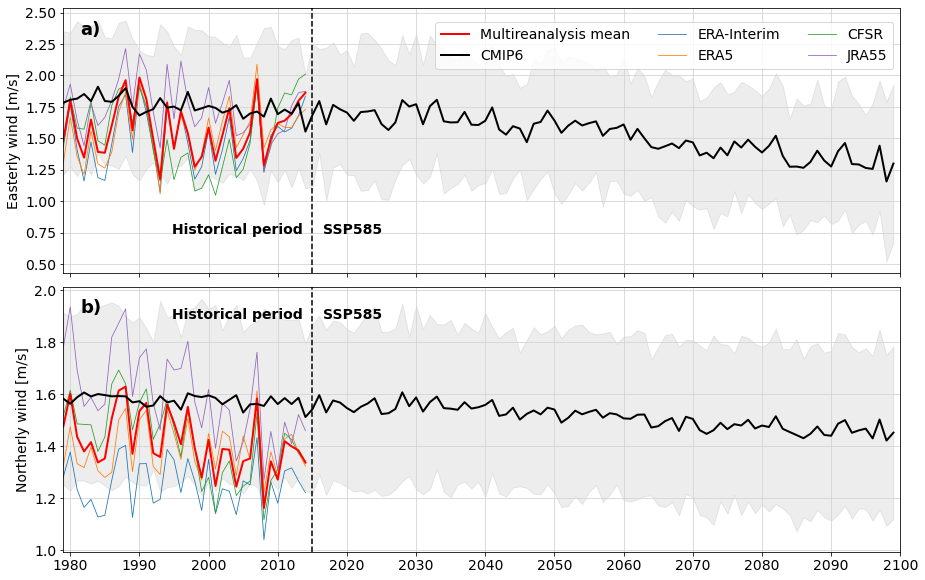

In [17]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (15,10))
gr = gs.GridSpec(2, 1, figure = fig, hspace = .05, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[1,0])]
for ax, label in zip(axs, ['a)', 'b)']):
    ax.text(0.02, .9, label, transform = ax.transAxes, size = 18, weight = 'bold')
    ax.grid(linestyle = '-', color = 'lightgrey')
    ax.set_xticks(np.arange(1980, 2110, 10))
    if ax == axs[0]:
        ax.set_xticklabels([])
    else:
        ax.set_xticklabels(np.arange(1980, 2110, 10))
    ax.set_xlim(1979, 2100)
        
for k, cl in zip(keys[:-2], [Tableau_10.mpl_colors[0], Tableau_10.mpl_colors[1], Tableau_10.mpl_colors[2], Tableau_10.mpl_colors[4]]):
    axs[0].plot(u_ave[k]['year'], -u_ave[k], color = cl, linewidth = .8, label = k)
    axs[1].plot(v_ave[k]['year'], v_ave[k], color = cl, linewidth = .8, label = k)
axs[0].plot(u_ave['reanalysis']['year'], -u_ave['reanalysis'], color = 'r', linewidth = 2, label = 'Multireanalysis mean')
axs[0].plot(u_cmip_complete['year'], -u_cmip_complete, color = 'k', linewidth = 2, label = 'CMIP6')
axs[0].fill_between(u_cmip_complete['year'], -u_cmip_complete+usd_cmip_complete, -u_cmip_complete-usd_cmip_complete, color = 'k', alpha = 0.07)
axs[0].set_ylabel('Easterly wind [m/s]')

axs[1].plot(v_ave['reanalysis']['year'], v_ave['reanalysis'], color = 'r', linewidth = 2, label = 'Multireanalysis mean')
axs[1].plot(v_cmip_complete['year'], v_cmip_complete, color = 'k', linewidth = 2, label = 'CMIP6')
axs[1].fill_between(v_cmip_complete['year'], v_cmip_complete-vsd_cmip_complete, v_cmip_complete+vsd_cmip_complete, color = 'k', alpha = 0.07)
axs[1].set_ylabel('Northerly wind [m/s]')
axs[0].axvline(x = 2015, linestyle = '--', color = 'k')
axs[1].axvline(x = 2015, linestyle = '--', color = 'k')

axs[0].text(0.13, .15, 'Historical period', transform = axs[0].transAxes, size = 14, weight = 'bold')
axs[0].text(0.31, .15, 'SSP585', transform = axs[0].transAxes, size = 14, weight = 'bold')
axs[1].text(0.13, .88, 'Historical period', transform = axs[1].transAxes, size = 14, weight = 'bold')
axs[1].text(0.31, .88, 'SSP585', transform = axs[1].transAxes, size = 14, weight = 'bold')

fig.legend(handles = legend_elements, ncol = 3, bbox_to_anchor = (0.9, 0.87))

# Quantify trends

In [18]:
u_cmip_concat = xr.concat([u_ave_xarray, u_ave_xarray_proj.drop_sel(model = 'cmip6')], dim = 'year')

In [19]:
MK_class = Mann_Kendall_test(-u_cmip_concat, 'time', coords_name = {'year':'time', 'model':'x'})
ut_cmip6 = MK_class.compute()

In [20]:
v_cmip_concat = xr.concat([v_ave_xarray, v_ave_xarray_proj.drop_sel(model = 'cmip6')], dim = 'year')

In [21]:
MK_class = Mann_Kendall_test(v_cmip_concat, 'time', coords_name = {'year':'time', 'model':'x'})
vt_cmip6 = MK_class.compute()

In [22]:
from scipy import stats as st

In [23]:
ut_cmip6_mmm = -st.linregress(np.arange(0, 121, 1), u_cmip_complete).slope
vt_cmip6_mmm = st.linregress(np.arange(0, 121, 1), v_cmip_complete).slope

In [24]:
u_re_concat = u_ave['reanalysis']
v_re_concat = v_ave['reanalysis']
for k in keys[:-2]:
    u_re_concat = xr.concat([u_re_concat, u_ave[k]], dim = 'model')
    v_re_concat = xr.concat([v_re_concat, v_ave[k]], dim = 'model')
u_re_concat['model'] = ['reanalysis']+keys[:-2]
v_re_concat['model'] = ['reanalysis']+keys[:-2]

In [25]:
MK_class = Mann_Kendall_test(-u_re_concat, 'time', coords_name = {'year':'time', 'model':'x'})
ut_re = MK_class.compute()
MK_class = Mann_Kendall_test(v_re_concat, 'time', coords_name = {'year':'time', 'model':'x'})
vt_re = MK_class.compute()

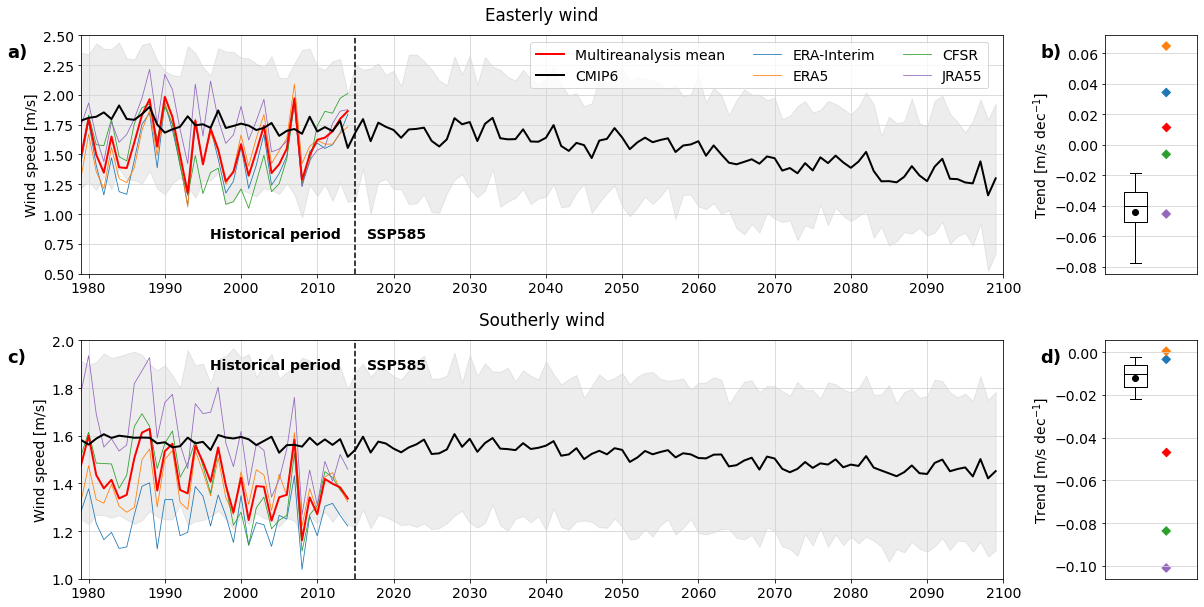

In [26]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (20,10))
gr = gs.GridSpec(2, 2, figure = fig, hspace = 0.28, width_ratios = [1, .1])
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[0,1]),
       fig.add_subplot(gr[1,1])]
for ax, label in zip(axs, ['a)', 'c)', 'b)', 'd)']):
    ax.grid(linestyle = '-', color = 'lightgrey')
    if ax in axs[:2]:
        ax.text(-0.08, .91, label, transform = ax.transAxes, size = 18, weight = 'bold')
        ax.set_xticks(np.arange(1980, 2110, 10))
        ax.set_xlim(1979, 2100)
    else:
        ax.text(-0.7, .91, label, transform = ax.transAxes, size = 18, weight = 'bold')
        ax.set_xlim(0.8, 1.4)
        
for k, cl in zip(keys[:-2], [Tableau_10.mpl_colors[0], Tableau_10.mpl_colors[1], Tableau_10.mpl_colors[2], Tableau_10.mpl_colors[4]]):
    axs[0].plot(u_ave[k]['year'], -u_ave[k], color = cl, linewidth = .8, label = k)
    axs[1].plot(v_ave[k]['year'], v_ave[k], color = cl, linewidth = .8, label = k)
axs[0].plot(u_ave['reanalysis']['year'], -u_ave['reanalysis'], color = 'r', linewidth = 2, label = 'Multireanalysis mean')
axs[0].plot(u_cmip_complete['year'], -u_cmip_complete, color = 'k', linewidth = 2, label = 'CMIP6')
axs[0].fill_between(u_cmip_complete['year'], -u_cmip_complete+usd_cmip_complete, -u_cmip_complete-usd_cmip_complete, color = 'k', alpha = 0.07)

axs[1].plot(v_ave['reanalysis']['year'], v_ave['reanalysis'], color = 'r', linewidth = 2, label = 'Multireanalysis mean')
axs[1].plot(v_cmip_complete['year'], v_cmip_complete, color = 'k', linewidth = 2, label = 'CMIP6')
axs[1].fill_between(v_cmip_complete['year'], v_cmip_complete-vsd_cmip_complete, v_cmip_complete+vsd_cmip_complete, color = 'k', alpha = 0.07)

axs[0].set_ylim(0.5, 2.5)
axs[1].set_ylim(1, 2)
axs[0].set_title('Easterly wind', pad = 15)
axs[0].set_ylabel('Wind speed [m/s]')
axs[1].set_title('Southerly wind', pad = 15)
axs[1].set_ylabel('Wind speed [m/s]')
axs[0].axvline(x = 2015, linestyle = '--', color = 'k')
axs[1].axvline(x = 2015, linestyle = '--', color = 'k')
axs[0].text(0.14, .15, 'Historical period', transform = axs[0].transAxes, size = 14, weight = 'bold')
axs[0].text(0.31, .15, 'SSP585', transform = axs[0].transAxes, size = 14, weight = 'bold')
axs[1].text(0.14, .88, 'Historical period', transform = axs[1].transAxes, size = 14, weight = 'bold')
axs[1].text(0.31, .88, 'SSP585', transform = axs[1].transAxes, size = 14, weight = 'bold')

axs[2].boxplot(ut_cmip6['trend']*10,
               showfliers = False, medianprops=dict(color='k'))
axs[2].scatter(np.ones(1), ut_cmip6_mmm*10, c = 'k')
axs[2].scatter(np.ones(1)+.2, ut_re['trend'].sel(x = 'reanalysis')*10, c = 'r', marker = 'D')
axs[2].scatter(np.ones(4)+.2, ut_re['trend'].sel(x = keys[:-2])*10,
               c = [Tableau_10.mpl_colors[0], Tableau_10.mpl_colors[1], Tableau_10.mpl_colors[2], Tableau_10.mpl_colors[4]],
               marker = 'D')
axs[3].boxplot(vt_cmip6['trend']*10,
               showfliers = False, medianprops=dict(color='k'))
axs[3].scatter(np.ones(1), vt_cmip6_mmm*10, c = 'k')
axs[3].scatter(np.ones(1)+.2, vt_re['trend'].sel(x = 'reanalysis')*10, c = 'r', marker = 'D')
axs[3].scatter(np.ones(4)+.2, vt_re['trend'].sel(x = keys[:-2])*10,
               c = [Tableau_10.mpl_colors[0], Tableau_10.mpl_colors[1], Tableau_10.mpl_colors[2], Tableau_10.mpl_colors[4]],
               marker = 'D')

axs[2].set_xticks([])
axs[2].set_xticklabels([])
axs[3].set_xticks([])
axs[3].set_xticklabels([])
axs[2].set_ylabel('Trend [m/s dec$^{-1}$]')
axs[3].set_ylabel('Trend [m/s dec$^{-1}$]')

fig.legend(handles = legend_elements, ncol = 3, bbox_to_anchor = (0.76, 0.88))

plt.savefig('../results/v5/fig4.jpg', bbox_inches = 'tight')